# Lab 4 - Multicollinearity & Logistic Regression

In this lab, we'll be analyzing the following:
1. Interpreting a multivariate linear regression
1. Examining multicollinearity & Variance Inflation Factors (VIF)
1. Introducing predicted values
1. Examining homoscedasticity
1. Introducing logistic regression and odds ratio

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor ### VIF package
from statsmodels.discrete.discrete_model import Logit

### 1. Load & Clean the Data

In [2]:
raw = pd.read_csv ('data.csv')
raw.head()

Unnamed: 0     id  price_000  apt  floor  age_0_10  age_10_20  age_20_more  \
0           0  40003      60000    1      5         1          0            0   
1           1  40007     140000    0      0         0          1            0   
2           2  40008      38000    1      1         0          1            0   
3           3  40010     110000    0      0         0          1            0   
4           4  40011     120000    0      0         0          1            0   

   num_room  num_bath  ...  pcnt_com  pcnt_insti  pcnt_vacant  pcn_green  \
0         3         2  ...      0.00        0.49          0.0       1.74   
1         4         4  ...     15.41        1.32          0.0       0.54   
2         3         4  ...      8.16        5.57          0.0       1.55   
3         4         4  ...      8.11        5.53          0.0       1.58   
4         4         2  ...      0.00        0.00          0.0       0.40   

   homicides  house  ses_bin   lnprice  price_hi  year  
0      39.92      0        0  11.00210         0  2001  
1      46.00      1        0  11.84940         1  2002  
2      45.87      0        0  10.54534         0  2002  
3      45.88      1        0  11.60824         1  2002  
4      46.00      1        0  11.69525         1  2002  

[5 rows x 25 columns]

Create a copy with only the variables of interest

In [3]:
var_list = ['price_000','pop_dens','ses','house','area_m2','num_bath','pcn_green','homicides', 'year']
data = raw[var_list].copy()

data.head()

price_000  pop_dens  ses  house  area_m2  num_bath  pcn_green  homicides  \
0      60000    830.78    4      0       70         2       1.74      39.92   
1     140000    826.75    4      1      257         4       0.54      46.00   
2      38000    914.15    4      0      115         4       1.55      45.87   
3     110000    911.25    4      1      270         4       1.58      45.88   
4     120000    757.37    4      1      268         2       0.40      46.00   

   year  
0  2001  
1  2002  
2  2002  
3  2002  
4  2002

#### Recoding Variables

Let's redefine the socieconomic status - this is the same process we did in lab 3!

In [4]:
#Create SES Dummy Variable
data['high_ses'] = np.where(data['ses']>=5, 1, 0)

Now, let's create dummy variables for the year the property was sold. There are 6 unique years, and we can create a new dummy column for each year. This could be a long process, but python can make this easier for us!

In [5]:
#Pandas '.get_dummies()' Function
dummies = pd.get_dummies(data['year'], prefix = 'yr') 
#If we don't specify drop_first=True, python will give us a dummy column for every year
#Remember we'll always need to exclude one dummy in our regression model - it helps to think
#through which value you want to be your base comparison!

dummies.head()

yr_2001  yr_2002  yr_2003  yr_2004  yr_2005  yr_2006
0        1        0        0        0        0        0
1        0        1        0        0        0        0
2        0        1        0        0        0        0
3        0        1        0        0        0        0
4        0        1        0        0        0        0

In [6]:
#Append the dummies to our larger dataframe
data = pd.concat([data, dummies], axis = 1)
data.head()

price_000  pop_dens  ses  house  area_m2  num_bath  pcn_green  homicides  \
0      60000    830.78    4      0       70         2       1.74      39.92   
1     140000    826.75    4      1      257         4       0.54      46.00   
2      38000    914.15    4      0      115         4       1.55      45.87   
3     110000    911.25    4      1      270         4       1.58      45.88   
4     120000    757.37    4      1      268         2       0.40      46.00   

   year  high_ses  yr_2001  yr_2002  yr_2003  yr_2004  yr_2005  yr_2006  
0  2001         0        1        0        0        0        0        0  
1  2002         0        0        1        0        0        0        0  
2  2002         0        0        1        0        0        0        0  
3  2002         0        0        1        0        0        0        0  
4  2002         0        0        1        0        0        0        0

### 2. Estimate a Multivariate Linear Regression Model

We'll be running a similiar multivariate regression model to the one we used for Lab 3

In [7]:
#Define Independent Variables of Interest
ind_var = ['high_ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 'homicides','yr_2002','yr_2003','yr_2004','yr_2005','yr_2006'] 
#Note that the year variable is categorical. We need to exclude one to prevent collinearity issues with out model
#We will exclude year 2001 - we choose to have the earlier year be our base year

x = data[ind_var].assign(Intercept = 1) #Independent Variables
y = data['price_000'] #Dependent Variable

model = sm.OLS(y, x).fit()
### Let's save the results as "model" - this will be useful for other functions below.

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.526     
Dependent Variable:   price_000         AIC:                 97643.6615
Date:                 2020-02-19 12:43  BIC:                 97719.1179
No. Observations:     3976              Log-Likelihood:      -48810.   
Df Model:             11                F-statistic:         402.2     
Df Residuals:         3964              Prob (F-statistic):  0.00      
R-squared:            0.527             Scale:               2.7023e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
high_ses   72215.4064 3151.9478  22.9114 0.0000  66035.8154  78394.9973
house     -25760.7177 2439.5596 -10.5596 0.0000 -30543.6271 -20977.8084
area_m2      566.9380   14.3065  39.6279 0.0000    538.8891    594.9868
num_bath   10559.7664  957.8052  11.0250 0.0000   8681.9293  12437.6035
pcn_green    161.1475  115.4937   1.3953 0.1630    -65.2851    387.5801
homicides    -24.0329   16.0238  -1.4998 0.1337    -55.4485      7.3827
yr_2002     -265.7563 3186.9542  -0.0834 0.9335  -6513.9796   5982.4670
yr_2003     8079.4845 3055.2693   2.6444 0.0082   2089.4377  14069.5314
yr_2004     8448.0953 2749.0138   3.0731 0.0021   3058.4817  13837.7090
yr_2005    18176.6143 2862.9095   6.3490 0.0000  12563.7010  23789.5276
yr_2006    23245.8901 3213.0725   7.2348 0.0000  16946.4602  29545.3200
Intercept  -4589.4649 3273.0502  -1.4022 0.1609 -11006.4848   1827.5550
-----------------------------------------------------------------------
Omnibus:              3155.431       Durbin-Watson:          0.919     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       130563.264
Skew:                 3.445          Prob(JB):               0.000     
Kurtosis:             30.215         Condition No.:          1182      
=======================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

### 3. Let's Examine Multicolinearity!

First, let's examine the correlation matrix. If we take price to be our dependent variable - which of these variables will have a multicollinearity effect in our regression? We are looking at all the independent variables we used in out regression, defined as `ind_var`

In [8]:
data[ind_var].corr() #Note that 'price_000' was excluded, as it's the dependent variable

high_ses     house   area_m2  num_bath  pcn_green  homicides  \
high_ses   1.000000 -0.100795  0.102760  0.099413  -0.015300  -0.109577   
house     -0.100795  1.000000  0.651771  0.391207  -0.071164   0.002256   
area_m2    0.102760  0.651771  1.000000  0.530402  -0.081659  -0.155758   
num_bath   0.099413  0.391207  0.530402  1.000000   0.004428  -0.023408   
pcn_green -0.015300 -0.071164 -0.081659  0.004428   1.000000   0.400809   
homicides -0.109577  0.002256 -0.155758 -0.023408   0.400809   1.000000   
yr_2002    0.002373  0.091675  0.047662  0.119084  -0.031057  -0.005379   
yr_2003   -0.007941  0.105988  0.080717 -0.041298  -0.062284  -0.036070   
yr_2004   -0.005461 -0.004512  0.014372 -0.028751   0.024921  -0.009586   
yr_2005   -0.017378 -0.123877 -0.087158 -0.046473   0.070784   0.033238   
yr_2006    0.019602 -0.103324 -0.096463 -0.048293   0.049726   0.020638   

            yr_2002   yr_2003   yr_2004   yr_2005   yr_2006  
high_ses   0.002373 -0.007941 -0.005461 -0.017378  0.019602  
house      0.091675  0.105988 -0.004512 -0.123877 -0.103324  
area_m2    0.047662  0.080717  0.014372 -0.087158 -0.096463  
num_bath   0.119084 -0.041298 -0.028751 -0.046473 -0.048293  
pcn_green -0.031057 -0.062284  0.024921  0.070784  0.049726  
homicides -0.005379 -0.036070 -0.009586  0.033238  0.020638  
yr_2002    1.000000 -0.160412 -0.217704 -0.193765 -0.144172  
yr_2003   -0.160412  1.000000 -0.241674 -0.215099 -0.160046  
yr_2004   -0.217704 -0.241674  1.000000 -0.291923 -0.217208  
yr_2005   -0.193765 -0.215099 -0.291923  1.000000 -0.193323  
yr_2006   -0.144172 -0.160046 -0.217208 -0.193323  1.000000

Now, let's use the Variance Inflation Factor (VIF)

In [9]:
#Remembering what our x independent variables look like to python
print(type(x))
x.head() #It's a sub-dataframe!

<class 'pandas.core.frame.DataFrame'>


high_ses  house  area_m2  num_bath  pcn_green  homicides  yr_2002  yr_2003  \
0         0      0       70         2       1.74      39.92        0        0   
1         0      1      257         4       0.54      46.00        1        0   
2         0      0      115         4       1.55      45.87        1        0   
3         0      1      270         4       1.58      45.88        1        0   
4         0      1      268         2       0.40      46.00        1        0   

   yr_2004  yr_2005  yr_2006  Intercept  
0        0        0        0          1  
1        0        0        0          1  
2        0        0        0          1  
3        0        0        0          1  
4        0        0        0          1

In [10]:
# The VIF function does not understand what a dataframe is
print(type(x.values))
x.values

<class 'numpy.ndarray'>


array([[  0.,   0.,  70., ...,   0.,   0.,   1.],
       [  0.,   1., 257., ...,   0.,   0.,   1.],
       [  0.,   0., 115., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0., 145., ...,   0.,   0.,   1.],
       [  1.,   0., 175., ...,   0.,   0.,   1.],
       [  1.,   0.,  87., ...,   1.,   0.,   1.]])

In [11]:
vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])] 
#Use the x independent variables that include an intercept!
vif

[1.075589675218518,
 1.9161693482527897,
 2.2332929159454986,
 1.4449775982623985,
 1.215864231904951,
 1.2551838767376307,
 1.6485531975260321,
 1.762239899480357,
 2.0679255124189075,
 1.9741668537068202,
 1.6699697776375693,
 15.762164933163776]

Wow! What are these numbers?! What is going on? Let's add some labels to the data.

In [12]:
pd.Series(vif, index=x.columns)

high_ses      1.075590
house         1.916169
area_m2       2.233293
num_bath      1.444978
pcn_green     1.215864
homicides     1.255184
yr_2002       1.648553
yr_2003       1.762240
yr_2004       2.067926
yr_2005       1.974167
yr_2006       1.669970
Intercept    15.762165
dtype: float64

The variance_inflation_factor function can be confusing, we know. We wish it were simpler, we really do. The good thing is, you'll have it coded forever! The bad thing is, well... See above. If any of this is still unclear, or your eyes are glazing over the above, please come to office hours. We'll do our best to walk you through it, as many times as you might need it.

### 4. Now, let's do some homoscedasticity examination!

Before jumping right into this, let's looks at predicted values. To do this, we'll need the results of the regression model that we ran above.

Remember we saved the results of the linear regression under the "model" variable above:  
> model = sm.OLS(y, x).fit()

In [13]:
model.params # This will give us a summary of the regression coefficients.

high_ses     72215.406376
house       -25760.717730
area_m2        566.937955
num_bath     10559.766409
pcn_green      161.147505
homicides      -24.032871
yr_2002       -265.756311
yr_2003       8079.484548
yr_2004       8448.095346
yr_2005      18176.614300
yr_2006      23245.890063
Intercept    -4589.464902
dtype: float64

We can rewrite this into an equation form, as shown below:

$y = 27 215.4 * high\_ses\; \;- 25760.7 * house\; \;+566.9 * area\_m2\; \;+10559.7*num\_bath\; \;+161.1*pcn\_green\;\;-24.0*homicides$ <br> $-265.75*yr\_2002\;\;+8079.5*yr\_2003\;\;+8448.1*yr\_2004\;\;18176.6*yr\_2005\;\;+23245.9*yr\_2006\;\;-4589.5$

Now, let's try our first prediction! To do this, we are going to use the first line of observed data from the dataframe, as shown below:

In [14]:
x.head(1)

high_ses  house  area_m2  num_bath  pcn_green  homicides  yr_2002  yr_2003  \
0         0      0       70         2       1.74      39.92        0        0   

   yr_2004  yr_2005  yr_2006  Intercept  
0        0        0        0          1

$y = 27 215.4 * 0\; \;- 25760.7 * 0\; \;+566.9 * 70\; \;+10559.7*2\; \;+161.1*1.74\;\;-24.0*39.92$ <br> $-265.75*0\;\;+8079.5*0\;\;+8448.1*0\;\;18176.6*0\;\;+23245.9*0\;\;-4589.5$

In [37]:
model.predict(x.iloc[0].values)

array([55536.72918819])

How does this compare to the observed price value for that observation?

In [40]:
data.head(1)

price_000  pop_dens  ses  house  area_m2  num_bath  pcn_green  homicides  \
0      60000    830.78    4      0       70         2       1.74      39.92   

   year  high_ses  yr_2001  yr_2002  yr_2003  yr_2004  yr_2005  yr_2006  \
0  2001         0        1        0        0        0        0        0   

   high_price  
0           0

What do you think the residual of this prediction is?

In [41]:
model.resid[0]

4463.270811805647

Now, we can tell python to show us the predictions and residuals for every single observation in our dataset.

In [42]:
model.predict()

array([ 55536.72918819, 156307.68860246, 101729.10004194, ...,
        93122.04839759, 201649.96657363, 155558.38614588])

In [44]:
model.resid

0         4463.270812
1       -16307.688602
2       -63729.100042
3       -53848.359361
4       -21401.912634
            ...      
3971    181878.988732
3972    267252.847832
3973    471302.951602
3974    498150.033426
3975    544441.613854
Length: 3976, dtype: float64

In [45]:
def homoscedasticity_plots(observed, prediction, residuals):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ### Figure 1
    x1 = prediction
    y1 = residuals
    ### Figure 2
    x2 = observed
    y2 = residuals

    ### Creates title for overall figure
    plt.suptitle('Residuals vs. observed and fitted data')

    ### Creates first plot
    ax1.scatter(x1, y1)
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ### Formats axis number to include thousands separator
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))

    ### Creates second plot
    ax2.scatter(x2, y2) ### We can change the color and marker type
    ax2.set_xlabel('Observed Values')

    ### Formats axis number to include thousands separator
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))

    plt.show()

In [19]:
observed = data['price_000'] 
### These are the observed values of prices

prediction = model.predict()
### These are the price predictions using the same x values as the data input

residuals = model.resid 
### These are the residuals of the prediction model

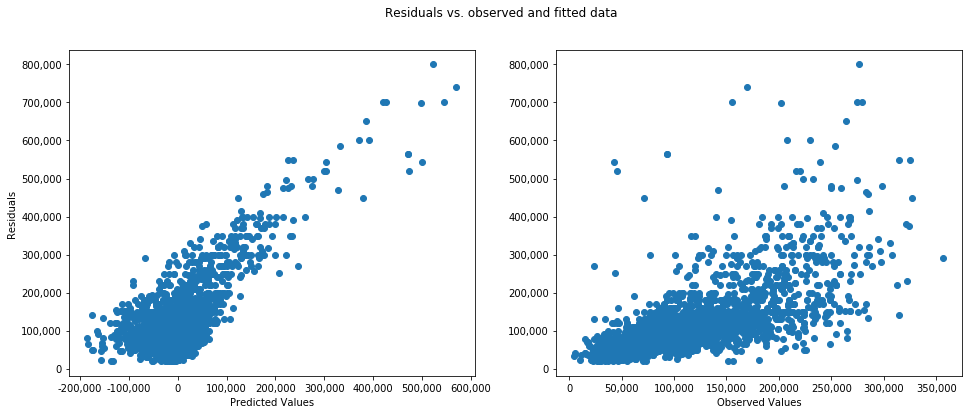

In [20]:
homoscedasticity_plots(prediction, residuals, observed)

### 5. Let's Do a Logit Regression!

Remember - logit regression are used when the DEPENDENT variable is a dummy variable (0 or 1). In this case, we are going to transform our price into a dummy variable, using the median as cutoff. We did this during lab 2!

In [21]:
price_median = data['price_000'].median()
print(price_median)

data['high_price'] = np.where(data['price_000']>price_median, 1, 0)
data.head()

72000.0


price_000  pop_dens  ses  house  area_m2  num_bath  pcn_green  homicides  \
0      60000    830.78    4      0       70         2       1.74      39.92   
1     140000    826.75    4      1      257         4       0.54      46.00   
2      38000    914.15    4      0      115         4       1.55      45.87   
3     110000    911.25    4      1      270         4       1.58      45.88   
4     120000    757.37    4      1      268         2       0.40      46.00   

   year  high_ses  yr_2001  yr_2002  yr_2003  yr_2004  yr_2005  yr_2006  \
0  2001         0        1        0        0        0        0        0   
1  2002         0        0        1        0        0        0        0   
2  2002         0        0        1        0        0        0        0   
3  2002         0        0        1        0        0        0        0   
4  2002         0        0        1        0        0        0        0   

   high_price  
0           0  
1           1  
2           0  
3           1  
4           1

In [22]:
y = data['high_price'] #Dependent Variable - it's a dummy!
x = data[ind_var].assign(Intercept = 1) #Independent Variables

x.head()

high_ses  house  area_m2  num_bath  pcn_green  homicides  yr_2002  yr_2003  \
0         0      0       70         2       1.74      39.92        0        0   
1         0      1      257         4       0.54      46.00        1        0   
2         0      0      115         4       1.55      45.87        1        0   
3         0      1      270         4       1.58      45.88        1        0   
4         0      1      268         2       0.40      46.00        1        0   

   yr_2004  yr_2005  yr_2006  Intercept  
0        0        0        0          1  
1        0        0        0          1  
2        0        0        0          1  
3        0        0        0          1  
4        0        0        0          1

In [23]:
logit_model = Logit(y, x).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.410658
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.408    
Dependent Variable: high_price       AIC:              3289.5511
Date:               2020-02-19 12:43 BIC:              3365.0074
No. Observations:   3976             Log-Likelihood:   -1632.8  
Df Model:           11               LL-Null:          -2755.8  
Df Residuals:       3964             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
high_ses     1.7720    0.1970    8.9932  0.0000   1.3858   2.1582
house       -0.3467    0.1312   -2.6433  0.0082  -0.6039  -0.0896
area_m2      0.0289    0.0014   20.8734  0.0000   0.0262   0.0316
num_bath     0.6346    0.0571   11.1054  0.0000   0.5226   0.7465
pcn_green    0.0426    0.0056    7.5450  0.0000   0.0315   0.0537
homicides   -0.0059    0.0009   -6.2730  0.0000  -0.0077  -0.0041
yr_2002     -0.1936    0.1786   -1.0842  0.2783  -0.5436   0.1564
yr_2003      0.5769    0.1704    3.3855  0.0007   0.2429   0.9108
yr_2004      0.5040    0.1507    3.3441  0.0008   0.2086   0.7995
yr_2005      0.9488    0.1555    6.1027  0.0000   0.6441   1.2535
yr_2006      1.5429    0.1697    9.0942  0.0000   1.2103   1.8754
Intercept   -4.6274    0.2231  -20.7368  0.0000  -5.0647  -4.1900
================================================================

"""

In [34]:
# Odds Ratios
or_table = np.exp(logit_model.conf_int()) #Exponentiate Confidence Intervals
or_table['Odds Ratio'] = np.exp(logit_model.params) #Exponentiate Coefficients

or_table.columns = ['2.5%', '97.5%', 'Odds Ratio'] #Name Columns
or_table

2.5%     97.5%  Odds Ratio
high_ses   3.998069  8.655421    5.882599
house      0.546701  0.914263    0.706985
area_m2    1.026550  1.032140    1.029341
num_bath   1.686351  2.109708    1.886189
pcn_green  1.032034  1.055128    1.043517
homicides  0.992298  0.995958    0.994126
yr_2002    0.580653  1.169267    0.823977
yr_2003    1.274952  2.486408    1.780463
yr_2004    1.231980  2.224358    1.655405
yr_2005    1.904214  3.502556    2.582560
yr_2006    3.354632  6.523208    4.677923
Intercept  0.006316  0.015146    0.009780